**This notebook explores data from user sessions from a travel start-up TravelTide.**  
The purpose is to develope user segments for a marketing rewarding program

In [33]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from customer_segmentation.utils import functions
importlib.reload(functions)

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

**Query data**

In [4]:
cohort = functions.read_from_db('customer_data_model')

display(cohort.shape)
display(pd.DataFrame({"dtypes": cohort.dtypes}).T)
cohort.head(3)

(172355, 31)

,user_id,age,has_children,is_married,cnt_trips,cnt_cancellations,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_flight_travel_days,sum_flight_price,avg_distance_km,sum_distance_km,avg_rooms,avg_hotel_nights,sum_hotel_price,min_signup_date,cnt_sessions,sum_page_clicks,days_active,avg_session_duration_seconds,has_flight_booked,has_hotel_booked,sum_flight_discount,sum_hotel_discount,cnt_flight_discount,cnt_hotel_discount,avg_flight_discount,avg_hotel_discount
dtypes,int64,int64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,float64


,user_id,age,has_children,is_married,cnt_trips,cnt_cancellations,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_flight_travel_days,sum_flight_price,avg_distance_km,sum_distance_km,avg_rooms,avg_hotel_nights,sum_hotel_price,min_signup_date,cnt_sessions,sum_page_clicks,days_active,avg_session_duration_seconds,has_flight_booked,has_hotel_booked,sum_flight_discount,sum_hotel_discount,cnt_flight_discount,cnt_hotel_discount,avg_flight_discount,avg_hotel_discount
0,264579,26,0,0,2.0,0.0,26.0,247,8.0,4.0,1.0,4.0,153.15,877.0,1754.0,1.0,3.0,2544.0,2022-07-28,8,140,273,129.0,1,1,0.0,0.0,1,2,0.15,0.13
1,264581,21,1,0,1.0,0.0,0.0,335,5.0,8.0,0.0,0.0,0.00,0.0,0.0,1.0,8.0,1320.0,2022-07-28,7,59,347,63.0,0,1,0.0,66.0,3,3,0.13,0.08
2,264582,42,0,1,3.0,0.0,107.0,110,7.0,4.0,1.0,4.0,696.83,2533.0,7599.0,1.0,3.0,1174.0,2022-07-28,7,205,323,216.0,1,1,0.0,0.0,1,1,0.15,0.10


In [5]:
sorted(cohort.columns.to_list())

['age',
 'avg_days_advance_booking',
 'avg_diff_trip_days',
 'avg_distance_km',
 'avg_flight_discount',
 'avg_flight_travel_days',
 'avg_hotel_discount',
 'avg_hotel_nights',
 'avg_rooms',
 'avg_seats',
 'avg_session_duration_seconds',
 'avg_travel_days',
 'cnt_cancellations',
 'cnt_flight_discount',
 'cnt_hotel_discount',
 'cnt_sessions',
 'cnt_trips',
 'days_active',
 'days_last_trip',
 'has_children',
 'has_flight_booked',
 'has_hotel_booked',
 'is_married',
 'min_signup_date',
 'sum_distance_km',
 'sum_flight_discount',
 'sum_flight_price',
 'sum_hotel_discount',
 'sum_hotel_price',
 'sum_page_clicks',
 'user_id']

**create meaningful KPIs**

In [6]:
# activity & engagement
cohort['month_active'] = cohort['days_active'] / 30
cohort['sessions_per_month'] = cohort['cnt_sessions'] / cohort['month_active']
cohort['trips_per_month'] = cohort['cnt_trips'] / cohort['month_active']
cohort['page_click_per_session'] = cohort['sum_page_clicks'] / cohort['cnt_sessions']
#cohort['trips_per_session'] = cohort['cnt_trips'] / cohort['cnt_sessions'] # redundant with trips_per_month

# bookings, discount & cancellations
cohort['total_booking_value'] = cohort['sum_hotel_price'] + cohort['sum_flight_price']
cohort['avg_booking_value'] = cohort['total_booking_value'] / cohort['cnt_trips']
cohort['customer_value_per_month'] = cohort['total_booking_value'] / cohort['month_active']

# total discount rate
cohort['total_discount_rate'] = round((cohort['sum_flight_discount'] + cohort['sum_hotel_discount']) / 
                                      (cohort['sum_flight_price'] + cohort['sum_hotel_price']), 2)
cohort['discount_per_km'] = cohort['sum_flight_discount'] / cohort['sum_distance_km']

cohort['cancellation_rate'] = cohort['cnt_cancellations'] / cohort['cnt_trips']


**data type transformations**

In [7]:
# convert data types
cohort['user_id'] = cohort['user_id'].astype(str)
cohort['cnt_trips'] = cohort['cnt_trips'].astype(int)
cohort['min_signup_date'] = pd.to_datetime(cohort['min_signup_date'])

In [8]:
share_user_not_booked = cohort[cohort['cnt_trips'] == 0]['user_id'].nunique() / cohort['user_id'].nunique()
print(f"Percent share of users without bookings: {share_user_not_booked * 100:.1f}%")

high_booking_values = cohort[(cohort['avg_booking_value'] >= 5000) & (cohort['cnt_trips'] > 0)]['user_id'].nunique() / cohort['user_id'].nunique()
print(f"Percent share of users with high booking values: {high_booking_values * 100:.1f}%") # users with outlier values have booked (keep them)

Percent share of users without bookings: 12.9%
Percent share of users with high booking values: 1.1%


**remove absolute and redundant metrics**

In [9]:
# remove columns not necessary for further analysis
columns_to_drop = ['cnt_flight_discount', 'cnt_hotel_discount', 'cnt_cancellations', 'cnt_sessions', 
                   'sum_distance_km', 'sum_flight_discount', 'sum_flight_price', 'sum_hotel_discount', 
                   'sum_hotel_price', 'total_booking_value', 'sum_page_clicks']
cohort = cohort.drop(columns=columns_to_drop)

In [10]:
# list all metrics
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols)
sorted(numeric_cols.to_list())

['age',
 'avg_booking_value',
 'avg_days_advance_booking',
 'avg_diff_trip_days',
 'avg_distance_km',
 'avg_flight_discount',
 'avg_flight_travel_days',
 'avg_hotel_discount',
 'avg_hotel_nights',
 'avg_rooms',
 'avg_seats',
 'avg_session_duration_seconds',
 'avg_travel_days',
 'cancellation_rate',
 'cnt_trips',
 'customer_value_per_month',
 'days_active',
 'days_last_trip',
 'discount_per_km',
 'month_active',
 'page_click_per_session',
 'sessions_per_month',
 'total_discount_rate',
 'trips_per_month']

In [11]:
# list binaries
sorted(binary_cols)

['has_children', 'has_flight_booked', 'has_hotel_booked', 'is_married']

**explore distributions**

In [12]:
cohort[numeric_cols].describe()

,age,cnt_trips,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_flight_travel_days,avg_distance_km,avg_rooms,avg_hotel_nights,days_active,avg_session_duration_seconds,avg_flight_discount,avg_hotel_discount,month_active,sessions_per_month,trips_per_month,page_click_per_session,avg_booking_value,customer_value_per_month,total_discount_rate,discount_per_km,cancellation_rate
count,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,172355.000000,150082.000000,172355.000000,150081.000000,135990.000000,150082.000000
mean,41.059731,1.987352,29.790148,76.665562,10.531856,4.653535,0.967463,3.655960,1831.839216,1.017313,4.029370,157.339044,131.390583,0.094968,0.063506,5.244635,1.444439,0.426212,15.947469,1014.544281,399.228659,0.018292,0.002233,0.013642
std,12.888147,1.313511,35.618342,61.290080,17.943291,3.611238,0.681070,3.236634,1812.462572,0.615631,3.572384,70.830752,140.565099,0.089718,0.069872,2.361025,0.709088,0.315655,6.945205,1142.226331,491.051503,0.054583,0.006019,0.099548
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,17.000000,0.000000,0.000000,1.000000,0.421348,0.000000,2.200000,-787.430000,-466.184211,-2.850000,0.000000,0.000000
25%,32.000000,1.000000,0.000000,29.000000,6.000000,3.000000,1.000000,2.000000,544.000000,1.000000,2.000000,101.000000,87.000000,0.000000,0.000000,3.366667,0.954545,0.206897,11.714286,432.413750,102.706998,0.000000,0.000000,0.000000
50%,40.000000,2.000000,22.000000,65.000000,8.000000,4.000000,1.000000,3.000000,1710.000000,1.000000,3.000000,148.000000,111.000000,0.100000,0.050000,4.933333,1.263158,0.382166,14.857143,700.020000,268.319149,0.000000,0.000000,0.000000
75%,49.000000,3.000000,46.000000,113.000000,9.000000,6.000000,1.000000,5.000000,2540.000000,1.000000,5.000000,207.000000,139.000000,0.150000,0.100000,6.900000,1.724138,0.597015,18.600000,1177.257500,527.830217,0.020000,0.001234,0.000000
max,90.000000,9.000000,328.000000,357.000000,337.000000,78.000000,11.000000,49.000000,19208.000000,6.000000,78.000000,357.000000,2234.000000,0.700000,0.550000,11.900000,7.272727,2.903226,154.666667,32760.000000,17081.343564,13.340000,0.238860,1.000000


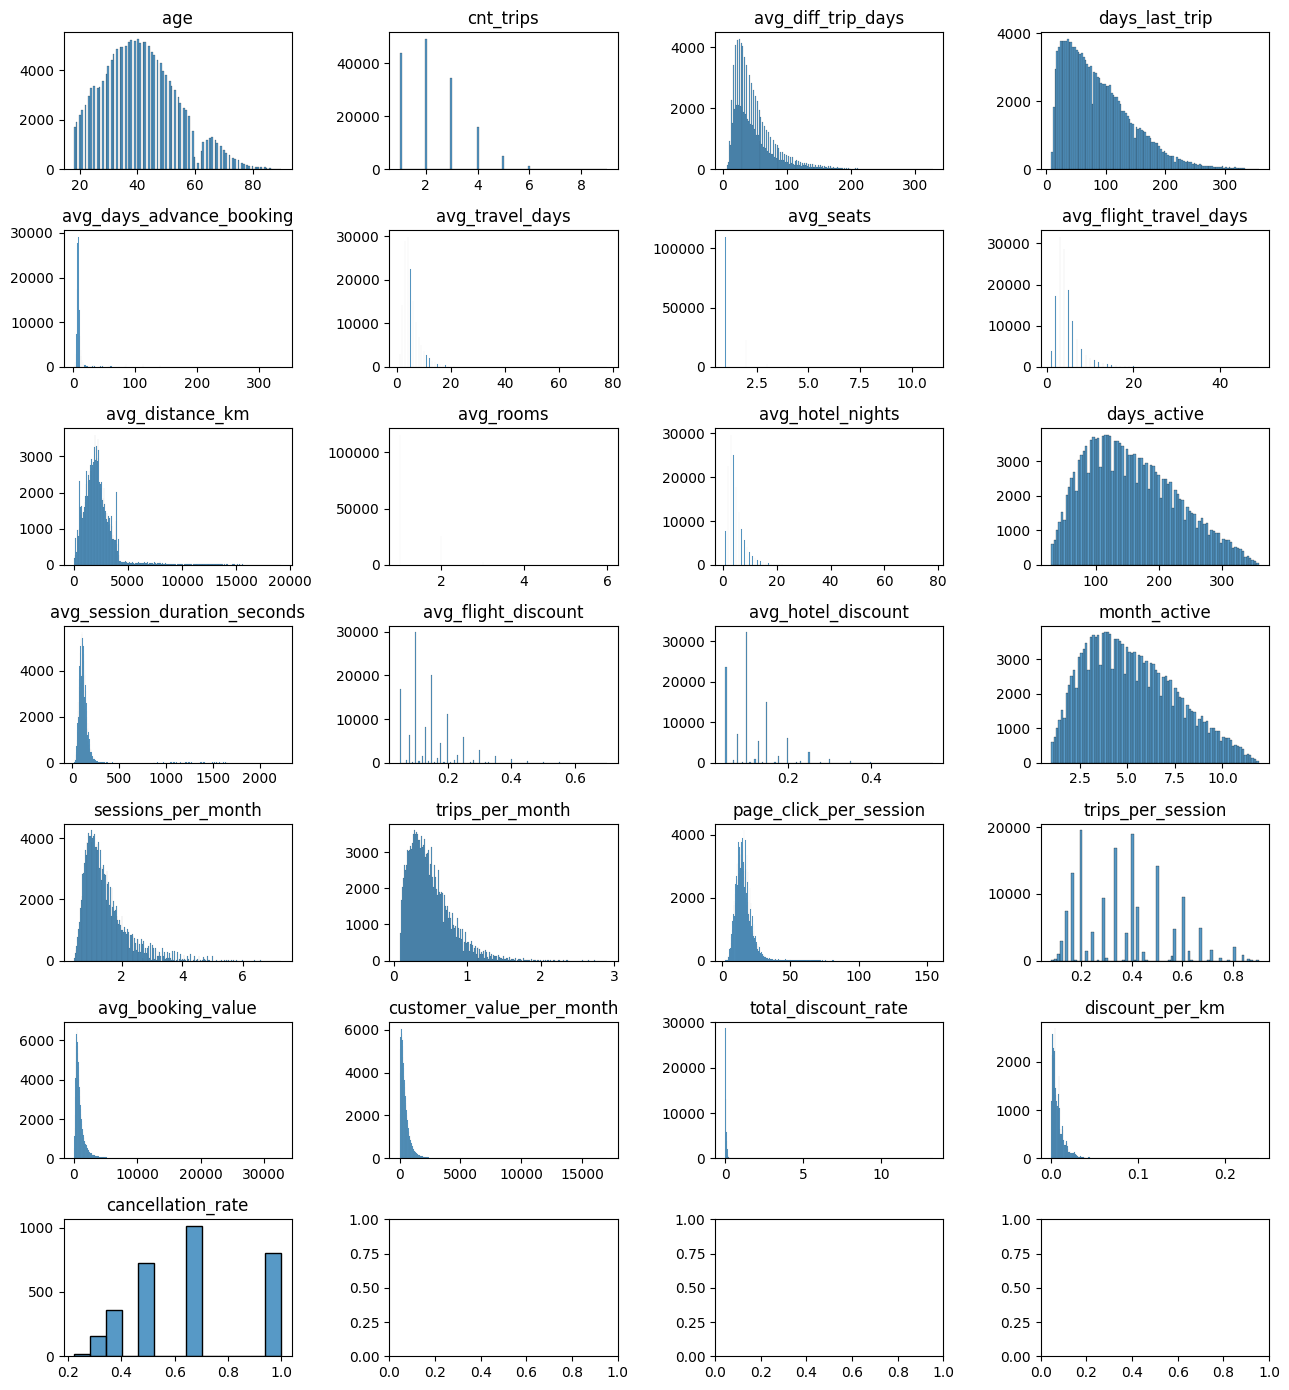

In [31]:
functions.plot_univariate_series(df=cohort, metrics=numeric_cols.to_list(), n_cols=4, plot_type=sns.histplot)

**Aggregated values per first session per user**

In [13]:
# aggregate by min session date
user_grouped_per_min_date = cohort.groupby(['min_signup_date']).agg(
    cnt_user = ('user_id', 'nunique'),
    days_active = ('days_active', 'mean'),
    avg_diff_days = ('avg_diff_trip_days', 'mean'),
    discount_rate = ('total_discount_rate', 'sum'),
    discount_per_km = ('discount_per_km', 'mean'),
    cancellation_rate = ('cancellation_rate', 'mean'),
    avg_booking_value = ('avg_booking_value', 'mean'),
    days_last_trip = ('days_last_trip', 'sum'),
    avg_travel_days = ('avg_travel_days', 'mean'),
    trips_per_month = ('trips_per_month', 'mean'),
    sessions_per_month = ('sessions_per_month', 'mean'),
    page_click_per_session = ('page_click_per_session', 'mean'),
).reset_index()

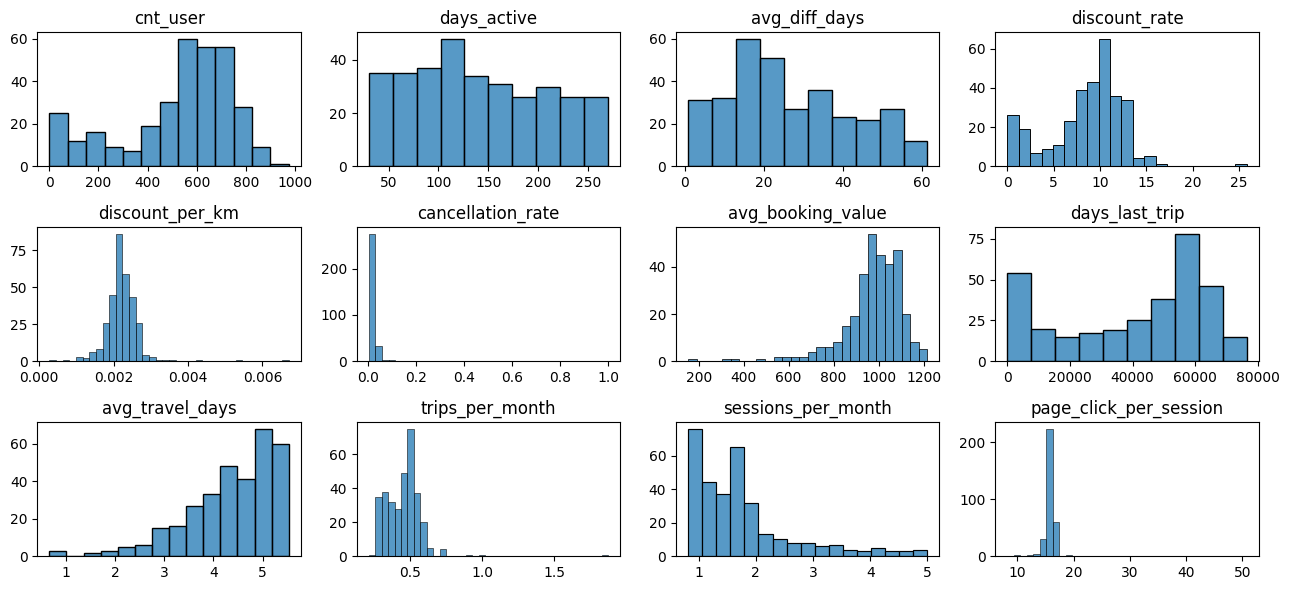

In [26]:
metrics = user_grouped_per_min_date.select_dtypes(include = [np.number]).columns.to_list()

functions.plot_univariate_series(df=user_grouped_per_min_date, metrics=metrics, n_cols=4, plot_type=sns.histplot)

**discover user pattern over time**  
 
- activity decreases overall over time  
- average duration between last booking and last session is stable

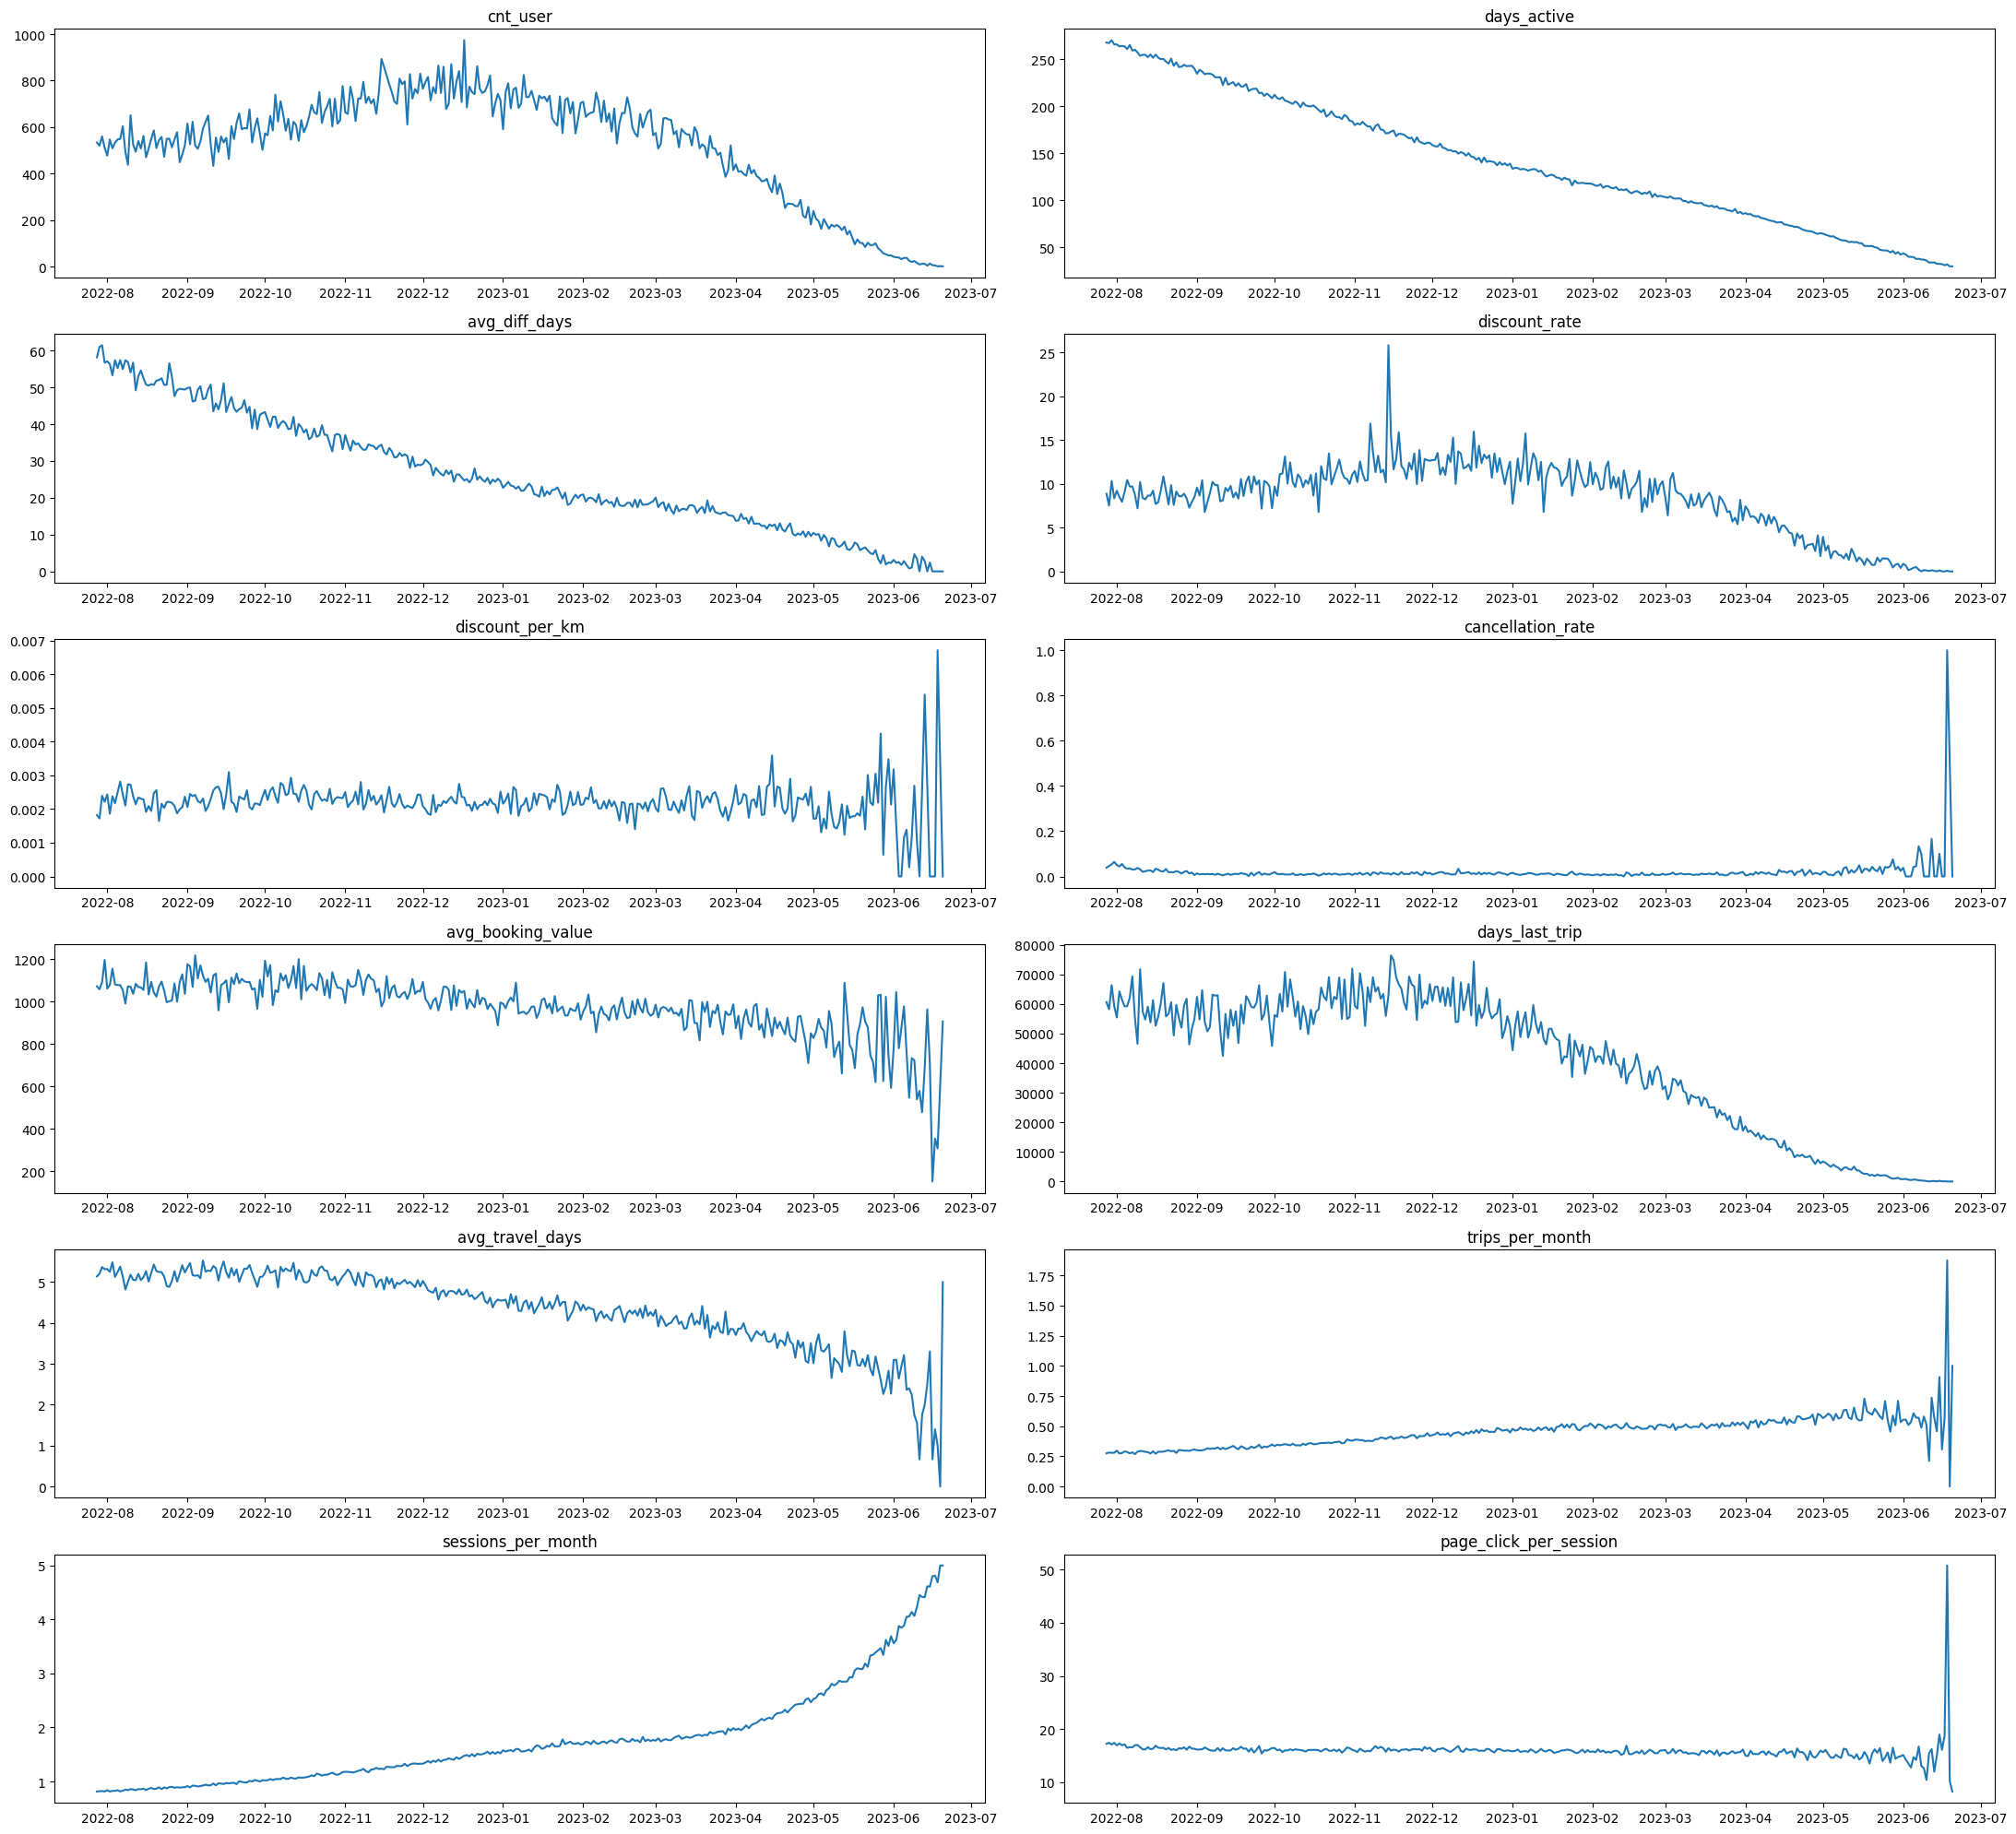

In [34]:
functions.plot_time_series(df=user_grouped_per_min_date, x=user_grouped_per_min_date.columns.values[0], y=list(user_grouped_per_min_date.columns.values[1:]))

In [35]:
# export data to csv file

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
data_path = os.path.join(data_dir, "cohort_data.csv")
cohort.to_csv(data_path, index=False)